In [1]:
rm(list=ls())
library(refund);
library(ggplot2)
library(dplyr); 
library(dplyr); 
library(reshape2); 
library(fda);
library(fdaACF)
library(fdapace)
library(fpca)
set.seed(100)

Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'reshape2' was built under R version 3.6.3"Loading required package: splines
Loading required package: Matrix
Warning message:
"package 'Matrix' was built under R version 3.6.3"Loading required package: fds
Warning message:
"package 'fds' was built under R version 3.6.3"Loading required package: rainbow
Warning message:
"package 'rainbow' was built under R version 3.6.3"Loading required package: MASS
Warning message:
"package 'MASS' was built under R version 3.6.3"
Attaching package: 'MASS'

The following object is masked from 'package:dplyr':

    select

Loading required package: pcaPP
Warning message:
"package 'pcaPP' was built under R version 3.6.3"Loading required package: RCurl
Warning message:


# Table of contents: tbd

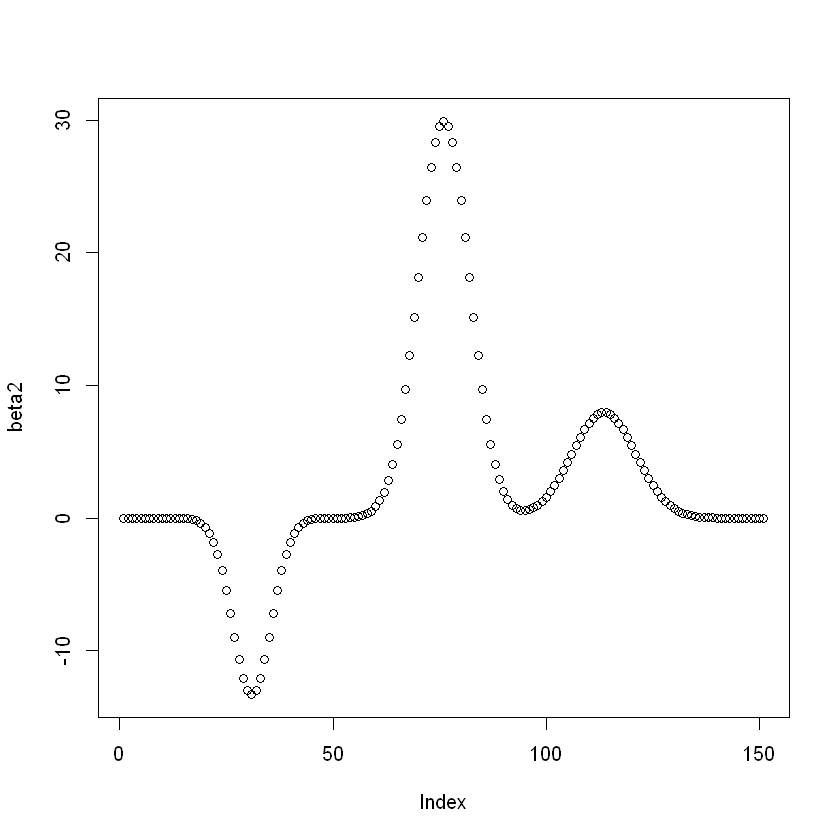

In [2]:
# set up "global" variables
n_obs = 60
n_var = 150 #number of vars
test = seq(1,20,1)
grid = seq(0, 1, length = n_var+1)

# set up functions here!
#smooth
f1 <- 2*sin(0.5*pi*grid) + 4*sin(1.5*pi*grid) + 5*sin(2.5*pi*grid)
#bumpy
f2 <- 1.5*exp(-0.5*(grid-0.3)^2/0.02^2) -
  4*exp(-0.5*(grid-0.45)^2/0.015^2) +
  8*exp(-0.5*(grid-0.6)^2/0.02^2) -
  exp(-0.5*(grid-0.8)^2/0.03^2)
beta1 = sin(grid * 2 * pi)
beta2 = -dnorm(grid, mean=.2, sd=.03) +3*dnorm(grid, mean=.5, sd=.04)+dnorm(grid, mean=.75, sd=.05)
fun_1 = 2*sin(grid*0.5*pi) +4*sin(grid*2.5*pi) + 5*sin(grid*2.5*pi)

nharm = 4 #number of fpc
plot(beta2)


In [3]:
data_generation <-function(fun){
    var1 = 1
    var2 = 2
    var3 = 0.2

    # X <- matrix(0, nrow=n_obs, ncol=length(grid))
    # for(i2 in 1:n_obs){
    #     X[i2,]=X[i2,]+rnorm(length(grid), 0, var1)
    #     X[i2,]=X[i2,]+runif(1, 0, var2)
    #     X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
        
    #     for(j2 in 1:10){
    #         e =rnorm(2, 0, var1/j2^(2))
    #         X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid*j2)
    #         X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid*j2)
    #     }
    # }
    # return(X)
    # }
    # This is a "more clear" setup

    X <- matrix(0, nrow=n_obs, ncol=length(grid))
    for(i2 in 1:n_obs){
        X[i2,]=X[i2,]+rnorm(length(grid), 2, var1)
        X[i2,]=X[i2,]+runif(1, 0, var2)
        X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
        X[i2,]=X[i2,]*fun

        for(j2 in 1:5){
           e =abs(rnorm(2, 0, var1/j2^(2)))
           X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid*j2)
           X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid*j2)
        }
        
    }
    return(X)
}


[1] "done"

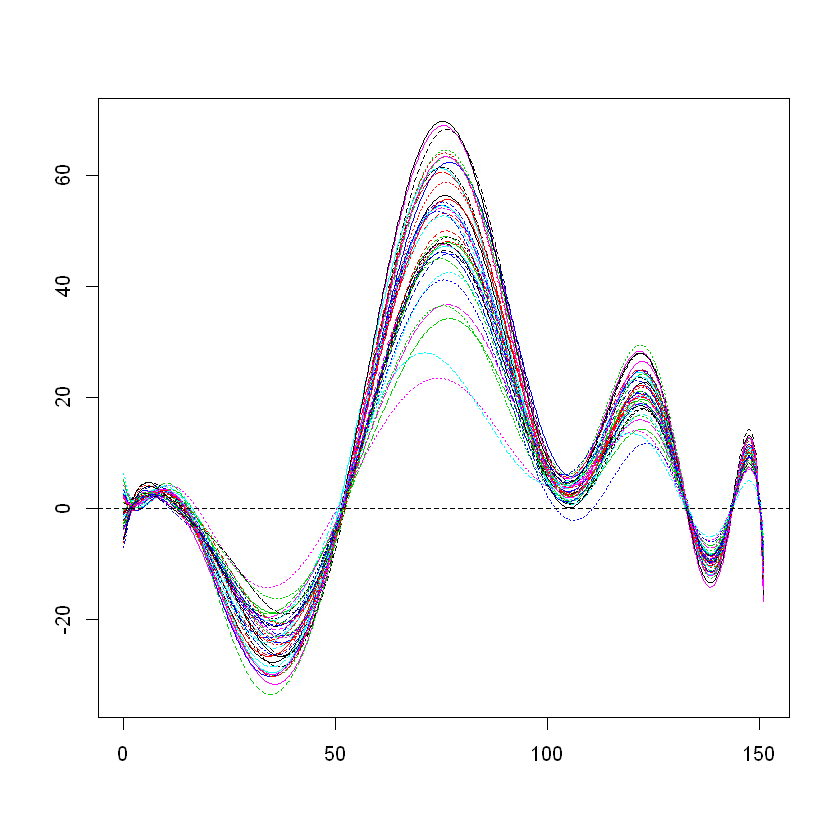

In [4]:
X = data_generation(beta2)
Y = X %*% (beta1/n_var) + rnorm(n_obs, 0, 0.125) 
Y = as.numeric(Y)
final_X = t(X)
X_train = final_X[,-test]
Y_train = Y[-test]
X_test = final_X[,test]
Y_test = Y[test]


smallbasis  <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = 12, 7)
#harmFdpar = fdPar(smallbasis)

smooth_basis_train <- smooth.basis(y = X_train, fdParobj=smallbasis)
smooth_basis_train_fd = smooth_basis_train$fd
smooth_basis_test <- smooth.basis(y = X_test, fdParobj=smallbasis)
smooth_basis_test_fd = smooth_basis_test$fd


# todo:use to choose appropriate level of explained variance

plot(smooth_basis_train_fd, ylab="", xlab="",col="gray")


[1] 0.3613107


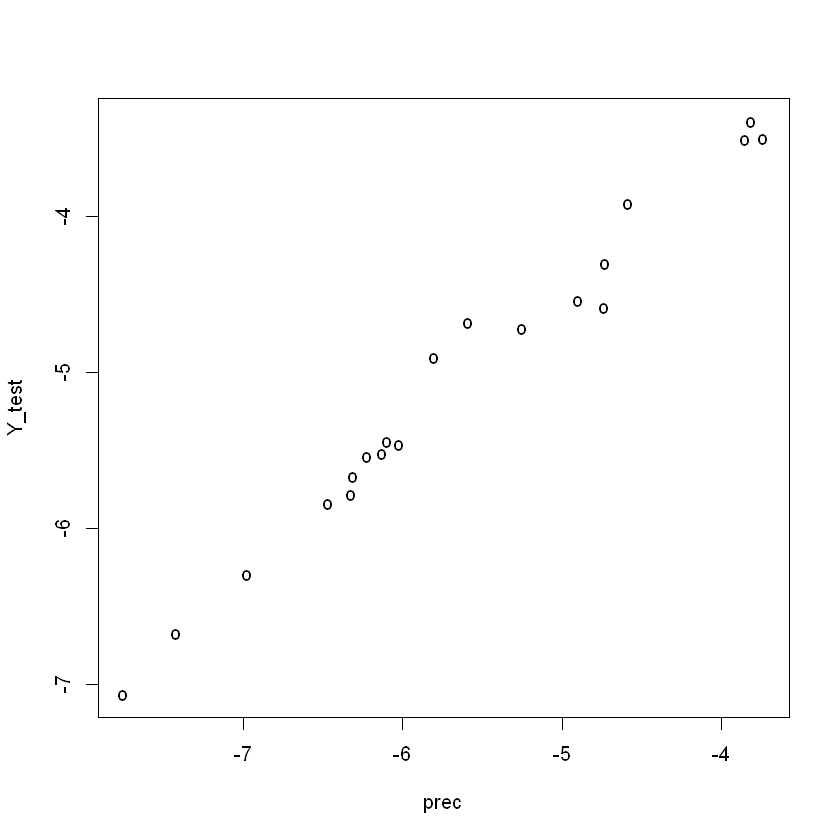

In [5]:
xfdlist = list( smooth_basis=smooth_basis_train_fd)
betabasis1 <- create.constant.basis(c(0, (n_obs-length(test))))
#betabasis_test <- create.constant.basis(c(0, length(test)))
betafd1    <- fd(0, betabasis1)
betafdPar1 <- fdPar(betafd1)
betafd2    <- create.bspline.basis(rangeval = c(0, n_var+1), nbasis = 12, 7)
betafdPar2  <- fdPar(betafd2)
betalist <- list(smooth_basis_fd=betafdPar2)

f_regress <- fRegress(y = Y_train, xfdlist, betalist, y2cMap = smooth_basis_train$y2cMap)
# also possible to use formula interface:
#f_regress2 <- fRegress(Y_train ~ smooth_basis_train_fd)
prec <- predict.fRegress(object = f_regress, 
                newdata = list(data = smooth_basis_test_fd))

# #  plot the data and the fit
#plot(f_regress$betaestlist[[2]])
# add true function plot
MSE_test <- mean((Y_test-prec)^2)
print(MSE_test)
plot(prec, Y_test, type="p", pch="o")




In [6]:
# construct standart errors!
# negative stderr???
res = c((Y_train - predict(f_regress))^2)

SigmaE = diag(res, 40) 
y2cMap = smooth_basis_train$y2cMap
std_err = fRegress.stderr(f_regress, y2cMap, SigmaE)
std_err$betastderrlist


[[1]]
$coefs
                [,1]
bspl7.1   1.55259440
bspl7.2   0.02152470
bspl7.3   0.02153855
bspl7.4   0.23645414
bspl7.5  -0.33407586
bspl7.6   0.49711695
bspl7.7  -0.59714950
bspl7.8   0.80842986
bspl7.9  -0.92495036
bspl7.10  1.14089145
bspl7.11 -1.08496873
bspl7.12  2.71879092

$basis
$call
basisfd(type = type, rangeval = rangeval, nbasis = nbasis, params = params, 
    dropind = dropind, quadvals = quadvals, values = values, 
    basisvalues = basisvalues)

$type
[1] "bspline"

$rangeval
[1]   0 151

$nbasis
[1] 12

$params
[1]  25.16667  50.33333  75.50000 100.66667 125.83333

$dropind
NULL

$quadvals
NULL

$values
list()

$basisvalues
list()

$names
 [1] "bspl7.1"  "bspl7.2"  "bspl7.3"  "bspl7.4"  "bspl7.5"  "bspl7.6" 
 [7] "bspl7.7"  "bspl7.8"  "bspl7.9"  "bspl7.10" "bspl7.11" "bspl7.12"

attr(,"class")
[1] "basisfd"

$fdnames
$fdnames$time
  [1]   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
 [19]  19  20  21  22  23  24  25  26  27  28  29  30  31

## FPCR

NULL

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),-5.450399527,0.0360657723,-151.1238821,7.244573e-51
data1,-0.015321653,0.0005555444,-27.5795276,2.481858e-25
data2,0.001028648,0.0018931906,0.5433408,5.903392e-01
data3,0.024279627,0.0028085373,8.6449368,3.311523e-10
data4,-0.015404892,0.0033681857,-4.5736469,5.773485e-05


[1] "done"

[1] 1.290751


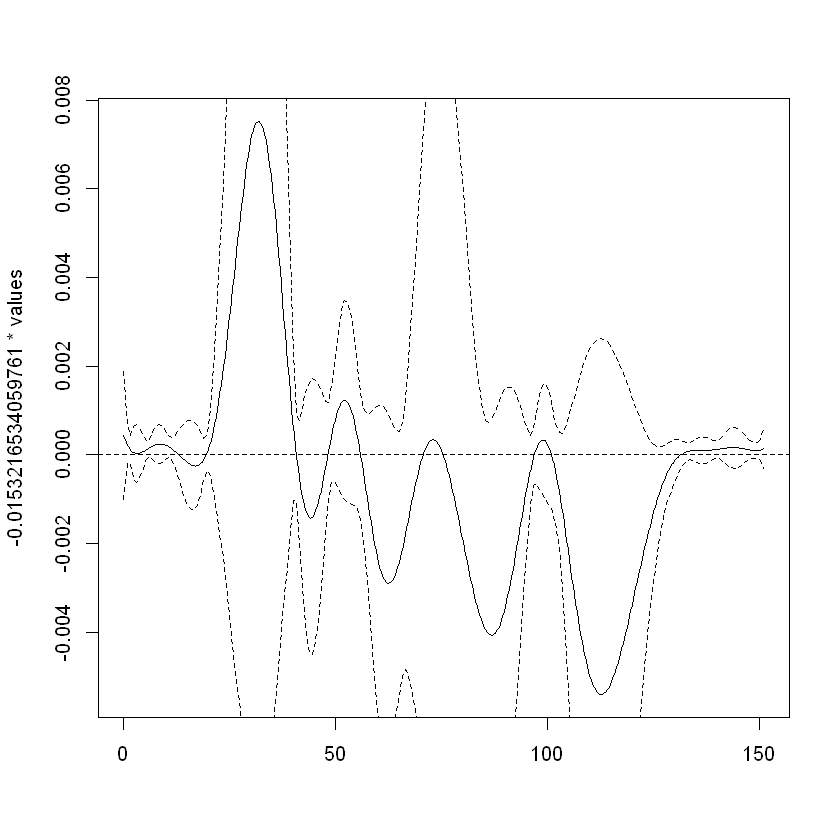

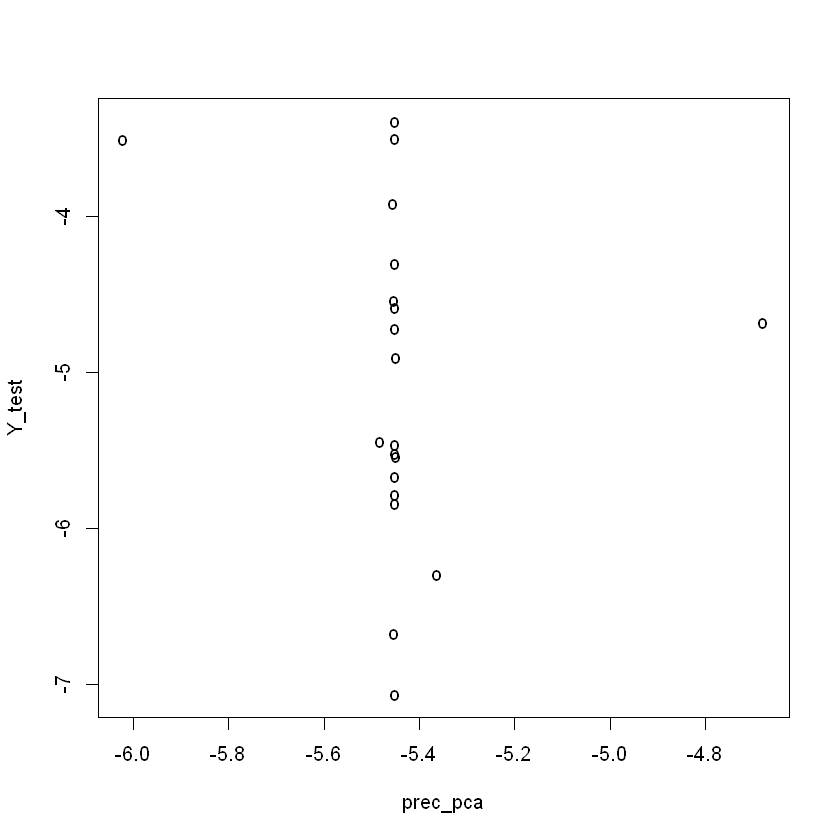

In [102]:
smallbasis  <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = 20, 5)
#harmFdpar = fdPar(smallbasis)

smooth_basis_train <- smooth.basis(y = X_train, fdParobj=smallbasis)
smooth_basis_train_fd_2 = smooth_basis_train$fd
smooth_basis_test <- smooth.basis(y = X_test, fdParobj=smallbasis)
smooth_basis_test_fd_2 = smooth_basis_test$fd


simulated_pcaObj_train2 = pca.fd(smooth_basis_train_fd_2, nharm = nharm,  centerfns = TRUE)
simulated_pcaObj_test2 = pca.fd(smooth_basis_test_fd_2, nharm = nharm, centerfns = TRUE)

#simulated_pcaObj_train$varprop 

data = simulated_pcaObj_train2$scores
f_regress_pca <- lm(Y_train ~ data)
f_regress_pca$coefs
pca_coeffs = summary(f_regress_pca)$coef
pca_coeffs

betafd = pca_coeffs[2,1]*simulated_pcaObj_train2$harmonics[1] +
        pca_coeffs[3,1]*simulated_pcaObj_train2$harmonics[2] + 
        pca_coeffs[4,1]*simulated_pcaObj_train2$harmonics[3]+ 
        pca_coeffs[5,1]*simulated_pcaObj_train2$harmonics[4]


coefvar = pca_coeffs[,2]**2
betavar = (pca_coeffs[2] * simulated_pcaObj_train2$harmonics[1])**2 +
          (pca_coeffs[3] * simulated_pcaObj_train2$harmonics[2])**2 +
          (pca_coeffs[4] * simulated_pcaObj_train2$harmonics[3])**2 + 
          (pca_coeffs[5] * simulated_pcaObj_train2$harmonics[4])**2

        #   This all has to become flexible! S.t we can choose the desired components that explain a
        #   certain amount of the variance and then this will become dynamic


plot(betafd)
lines(betafd+2*sqrt(betavar), lty=2, lwd=1)
lines(betafd-2*sqrt(betavar), lty=2, lwd=1)

########################
# JAKOB HELP US!!! / See WA Groupchat for possible solution!
########################
# we tried solution from here: https://stats.stackexchange.com/questions/419409/how-to-transform-test-data-in-functional-principal-component-analysis-in-r
# Maybe you can solve it....
mean_fd = simulated_pcaObj_train2$meanfd
data = t(simulated_pcaObj_train2$values * (t(simulated_pcaObj_train2$harmonics$coefs) %*% solve(cov(X_test)))) # wrong, but has structure we neeed, constructing following link but incomplete
frame = data.frame(data = data)

prec_pca <- predict.lm(object = f_regress_pca, frame)
MSE_test <- mean((Y_test-prec_pca)^2)
print(MSE_test)
plot(prec_pca, Y_test, type="p", pch="o")


## Sandbox for exploring more stuff

In [103]:
# implementation of refund package
fit <- fpcr(Y_train, xfuncs = X_train ,nbasis=seq(20,40,5), ncomp = seq(10,20,5), store.cv = TRUE)
refund_coeffs = fit$coefficient[2:5]
#summary(fit)


nbasis: 20 
nbasis: 25 
nbasis: 30 
nbasis: 35 
nbasis: 40 
nbasis: 25 


In [104]:
# Alternative :manually calculate the predictions
#a = 0.037941820
#matrix(simulated_pcaObj_test$scores, ncol = 4) %*% pca_coeffs[2:5,1] + a


## Simulation Study



In [2]:
rm(list=ls())

data_generation <-function(fun){
    var1 = 1
    var2 = 2
    var3 = 0.2

    X <- matrix(0, nrow=n_obs, ncol=length(grid))
    for(i2 in 1:n_obs){
        X[i2,]=X[i2,]+rnorm(length(grid), 2, var1)
        X[i2,]=X[i2,]+runif(1, 0, var2)
        X[i2,]=X[i2,]+rnorm(1, 0, var3)*grid
        X[i2,]=X[i2,]*fun

        for(j2 in 1:5){
           e =abs(rnorm(2, 0, var1/j2^(2)))
           X[i2,]=X[i2,]+e[1]*sin((2*pi)*grid*j2)
           X[i2,]=X[i2,]+e[2]*cos((2*pi)*grid*j2)
        }
        
    }
    return(X)
}

data(gasoline)
octane <- (gasoline$octane)
NIR    <- as.matrix(gasoline$NIR)
test_size = 20

# set up "global" variables
set.seed(100)
n_obs = 60
nharm = 4
n_var = 400
grid = seq(0, 1, length = n_var+1)
#smooth
f1 <- 2*sin(0.5*pi*grid) + 4*sin(1.5*pi*grid) + 5*sin(2.5*pi*grid)
#bumpy
f2 <- 1.5*exp(-0.5*(grid-0.3)^2/0.02^2) -  4*exp(-0.5*(grid-0.45)^2/0.015^2) +  8*exp(-0.5*(grid-0.6)^2/0.02^2) -  exp(-0.5*(grid-0.8)^2/0.03^2)

#two different variances of error
#sigma_eps_squared1 = as.numeric(2/3*var(NIR %*% f1))
#sigma_eps_squared2 = as.numeric(1/9*var(NIR %*% f1))
sigma_eps_squared1_1 = as.numeric((var(NIR %*% f1)/0.9) - var(NIR %*% f1))
sigma_eps_squared1_2 = as.numeric((var(NIR %*% f1)/0.6) - var(NIR %*% f1) )
sigma_eps_squared2_1 = as.numeric((var(NIR %*% f2)/0.9) - var(NIR %*% f2))
sigma_eps_squared2_2 = as.numeric((var(NIR %*% f2)/0.6) - var(NIR %*% f2) )

rep      <- 1000
MSE      <- matrix(NaN, nrow = rep, ncol = 9)
MSE_avrg = c()


for(j in seq(10,20,1)){
  for(i in 1 : rep){

    test = sample(1:n_obs, size = test_size, replace = FALSE)

    #each true beta and variance
    Y1_1 <- NIR %*% f1 + rnorm(n_obs, 0, sigma_eps_squared1_1)
    Y1_2 <- NIR %*% f1 + rnorm(n_obs, 0, sigma_eps_squared1_2)
    Y2_1 <- NIR %*% f2 + rnorm(n_obs, 0, sigma_eps_squared2_1)
    Y2_2 <- NIR %*% f2 + rnorm(n_obs, 0, sigma_eps_squared2_2)
    
    Y1_1 <- as.numeric(Y1_1)
    Y1_2 <- as.numeric(Y1_2)
    Y2_1 <- as.numeric(Y2_1)
    Y2_2 <- as.numeric(Y2_2)

    Y1_1train <- Y1_1[-test]
    Y1_2train <- Y1_2[-test]
    Y2_1train <- Y2_1[-test]
    Y2_2train <- Y2_2[-test]

    Y1_1test <- Y1_1[test]
    Y1_2test <- Y1_2[test]
    Y2_1test <- Y2_1[test]
    Y2_2test <- Y2_2[test]
    data = t(NIR)
    X_train = data[,-test]
    X_test = data[,test]

    #print(dim(NIR))
    smallbasis      <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = j, 8)
    smooth_basis_fd_train <- smooth.basis(y = X_train, fdParobj=smallbasis)$fd
    smooth_basis_fd_test <- smooth.basis(y = X_test, fdParobj=smallbasis)$fd

    xfdlist = list(smooth_basis=smooth_basis_fd_train)
    betabasis1 <- create.constant.basis(c(0, (60-length(test))))
    betafd1    <- fd(0, betabasis1)
    betafdPar1 <- fdPar(betafd1)
    betafd2    <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = j, 8)
    betafdPar2  <- fdPar(betafd2)
    betalist <- list(smooth_basis_fd=betafdPar2)

    f_regress1_1 <- fRegress(y = Y1_1train, xfdlist, betalist)
    f_regress1_2 <- fRegress(y = Y1_2train, xfdlist, betalist)
    f_regress2_1 <- fRegress(y = Y2_1train, xfdlist, betalist)
    f_regress2_2 <- fRegress(y = Y2_2train, xfdlist, betalist)
    
    prediction1_1 <- predict.fRegress(object = f_regress1_1, newdata = list(data = smooth_basis_fd_test))
    prediction1_2 <- predict.fRegress(object = f_regress1_2, newdata = list(data = smooth_basis_fd_test))
    prediction2_1 <- predict.fRegress(object = f_regress2_1, newdata = list(data = smooth_basis_fd_test))
    prediction2_2 <- predict.fRegress(object = f_regress2_2, newdata = list(data = smooth_basis_fd_test))
    
    MSE[i,1] <- mean((prediction1_1 - Y1_1test)^2)
    MSE[i,2] <- mean((prediction1_2 - Y1_2test)^2)
    MSE[i,3] <- mean((prediction2_1 - Y2_1test)^2)
    MSE[i,4] <- mean((prediction2_2 - Y2_2test)^2)
    
    

################################################################################

    simulated_pcaObj_train = pca.fd(smooth_basis_fd_train, nharm = nharm,  centerfns = TRUE)
    simulated_pcaObj_test = pca.fd(smooth_basis_fd_test, nharm = nharm, centerfns = TRUE)
    data = simulated_pcaObj_train$scores
    f_regress_pca <- lm(Y1_1train ~ data)
    data = simulated_pcaObj_test$scores
    prediction1_1 <- predict.lm(object = f_regress_pca, data.frame(data = data))

    data = simulated_pcaObj_train$scores
    f_regress_pca <- lm(Y1_2train ~ data)
    data = simulated_pcaObj_test$scores
    prediction1_2 <- predict.lm(object = f_regress_pca, data.frame(data = data))

    data = simulated_pcaObj_train$scores
    f_regress_pca <- lm(Y2_1train ~ data)
    data = simulated_pcaObj_test$scores
    prediction2_1 <- predict.lm(object = f_regress_pca, data.frame(data = data))

    data = simulated_pcaObj_train$scores
    f_regress_pca <- lm(Y2_2train ~ data)
    data = simulated_pcaObj_test$scores
    prediction2_2 <- predict.lm(object = f_regress_pca, data.frame(data = data))
    
    MSE[i,5] <- mean((prediction1_1 - Y1_1test)^2)
    MSE[i,6] <- mean((prediction1_2 - Y1_2test)^2)
    MSE[i,7] <- mean((prediction2_1 - Y2_1test)^2)
    MSE[i,8] <- mean((prediction2_2 - Y2_2test)^2)
    
    
    #var(NIR %*% f2)
  }#end of reps

    scaled_MSE <- colMeans(MSE)
    # scalling by var(X%*% tur_fun)
    for (i in seq(1,7,2)){
        scaled_MSE[i] = scaled_MSE[i] / var(NIR %*% f1)
    }
    for (i in seq(2,8,2)){
        scaled_MSE[i] = scaled_MSE[i] / var(NIR %*% f2)
    }
    scaled_MSE[9] = j
    
    
  
    MSE_avrg <- rbind(MSE_avrg, scaled_MSE)
  
}
colnames(MSE_avrg) = c("f1_e1_spline", "f1_e2_spline", "f2_e1_spline", "f2_e2_spline", "f1_e1_fpcr", "f1_e2_fpcr", "f2_e1_fpcr", "f2_e2_fpcr", "n_basis")
MSE_avrg

,f1_e1_spline,f1_e2_spline,f2_e1_spline,f2_e2_spline,f1_e1_fpcr,f1_e2_fpcr,f2_e1_fpcr,f2_e2_fpcr,n_basis
scaled_MSE,0.2913359,89.11867,0.009131105,1.246021,0.6787662,75.34912,0.2685719,3.237300,10
scaled_MSE,0.5944166,193.48949,0.029034363,3.500606,0.7027457,75.67353,0.2900499,3.475780,11
scaled_MSE,5.8335901,1891.73451,0.205180026,24.274937,0.7093014,77.79667,0.3210186,3.695288,12
scaled_MSE,0.6613067,223.80582,0.015962656,2.852267,0.7102092,76.78630,0.3247978,3.747103,13
scaled_MSE,0.7881590,268.53780,0.268072213,3.503345,0.7127943,76.15250,0.3354015,3.871568,14
scaled_MSE,0.8140645,243.70344,0.012005261,3.281299,0.7113073,75.27821,0.3391699,3.859333,15
scaled_MSE,1.6944910,485.46665,0.032569711,7.085854,0.7204190,76.60254,0.3147286,3.622932,16
scaled_MSE,1.5981076,481.84680,0.022847114,6.603382,0.7236508,75.03839,0.3091235,3.625584,17
scaled_MSE,1.6413804,515.66970,0.023444493,6.635775,0.7215166,78.06471,0.2787281,3.356777,18
scaled_MSE,6.8866837,1954.22275,0.088341775,26.883122,0.6747858,75.69708,0.2361793,3.006616,19


[1] "done"

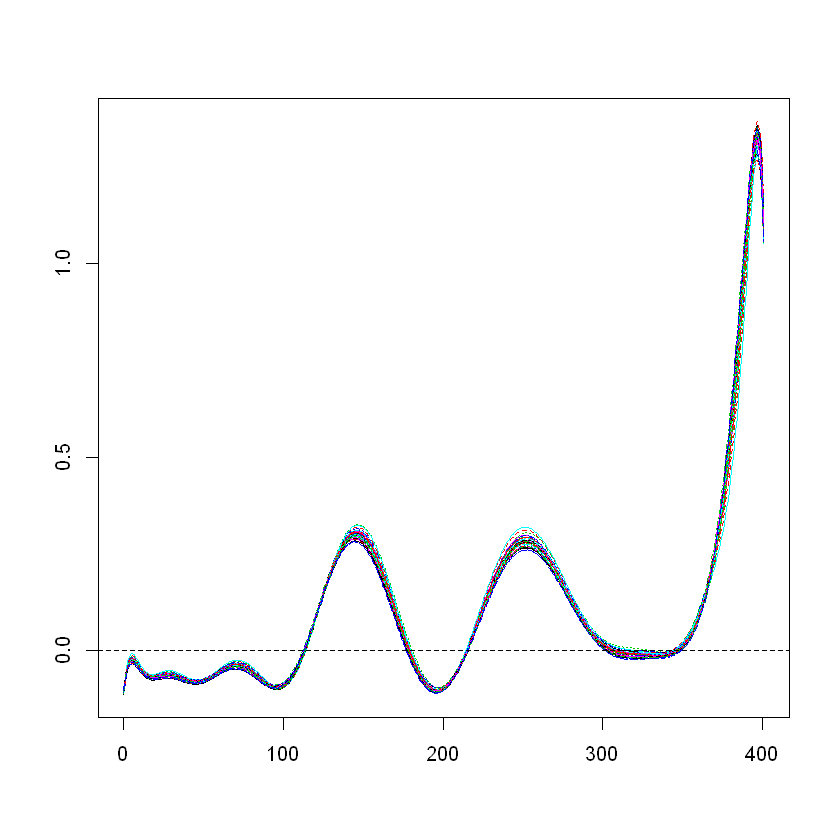

In [6]:
smallbasis      <- create.bspline.basis(rangeval = c(0, length(grid)), nbasis = 19, 8)
smooth_basis_fd_train_test <- smooth.basis(y = X_train, fdParobj=smallbasis)$fd
plot(smooth_basis_fd_train_test, ylab="", xlab="",col="gray")
